# Assignment-02: Geospatial EDA on US Road Accidents

In [1]:
import pandas as pd
DATA_PATH = 'US_Accidents_March23.csv'

# Load a sample if running locally with limited RAM
USE_SAMPLE = True ## USE THE SAMPLE DATASET NOT THE ENTIRE ONE
SAMPLE_FRAC = 0.1  # 10% sample

df = pd.read_csv(DATA_PATH)

if USE_SAMPLE:
    df = df.sample(frac=SAMPLE_FRAC, random_state=42).reset_index(drop=True)

df.shape, df.head()

((772839, 46),
           ID   Source  Severity                     Start_Time  \
 0  A-7182628  Source1         1            2020-04-17 09:29:30   
 1  A-5404588  Source1         2  2022-04-21 10:01:00.000000000   
 2   A-156000  Source3         3            2016-08-12 16:45:00   
 3  A-1871277  Source2         3            2019-09-20 15:22:16   
 4  A-2031222  Source2         2            2019-06-03 16:55:43   
 
                         End_Time  Start_Lat   Start_Lng    End_Lat  \
 0            2020-04-17 10:29:30  26.706900  -80.119360  26.706900   
 1  2022-04-21 11:44:08.000000000  38.781024 -121.265820  38.780377   
 2            2016-08-12 17:15:00  33.985249  -84.269348        NaN   
 3            2019-09-20 15:56:00  47.118706 -122.556908        NaN   
 4            2019-06-03 18:12:09  33.451355 -111.890343        NaN   
 
       End_Lng  Distance(mi)  ... Roundabout Station   Stop Traffic_Calming  \
 0  -80.119360         0.000  ...      False   False  False           Fals

## Q1. Spatial Distribution and Hotspots

**Question:**  
**Where are the major spatial hotspots of road accidents in the United States, and how do they differ across states and cities?**

### Tasks

1. Map accident locations using latitude and longitude to visualize overall spatial distribution (e.g., point map, heatmap, or coarse grid density map).  
2. Identify and list the top states and top cities by accident count and compare them using plots or summary tables.  
3. Highlight at least two clear hotspot regions and briefly interpret possible reasons (e.g., urbanization, highways, population density) using the spatial patterns observed.


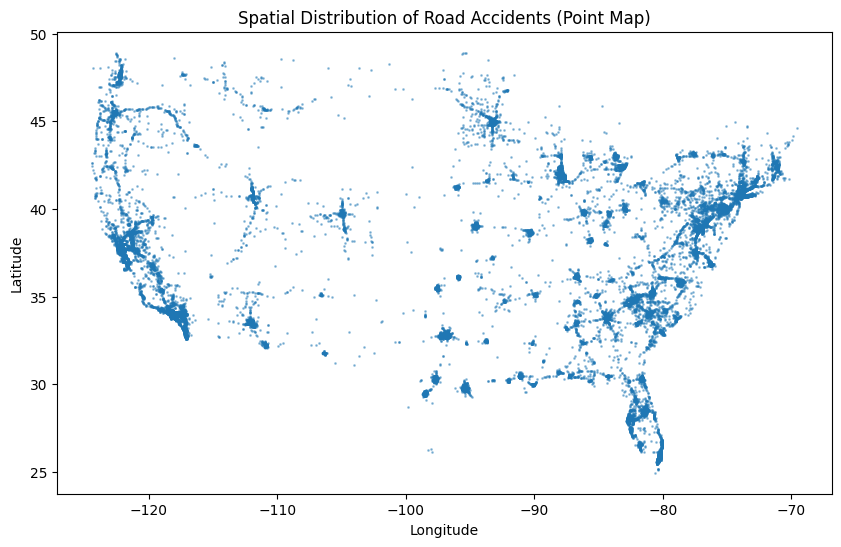

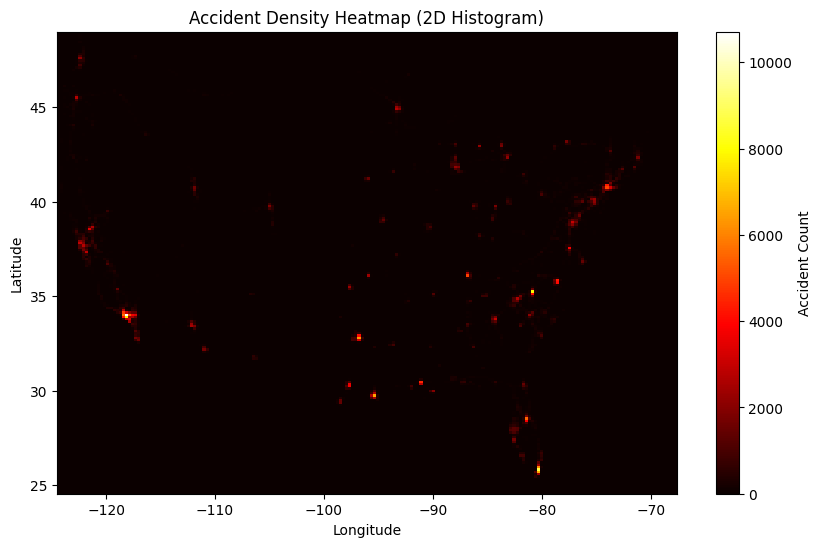

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
geo_df = df.dropna(subset=['Start_Lat', 'Start_Lng'])
sample_df = geo_df.sample(n=min(30000, len(geo_df)), random_state=42)

plt.figure(figsize=(10,6))
plt.scatter(
    sample_df['Start_Lng'],
    sample_df['Start_Lat'],
    s=1,
    alpha=0.4
)
plt.title('Spatial Distribution of Road Accidents (Point Map)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.figure(figsize=(10,6))
plt.hist2d(
    geo_df['Start_Lng'],
    geo_df['Start_Lat'],
    bins=200,
    cmap='hot'
)
plt.colorbar(label='Accident Count')
plt.title('Accident Density Heatmap (2D Histogram)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


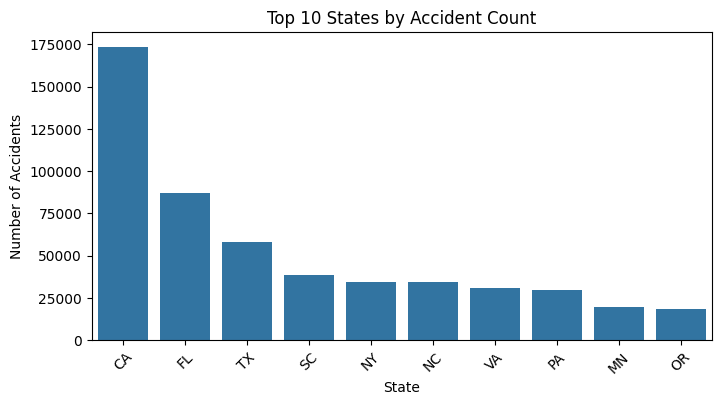

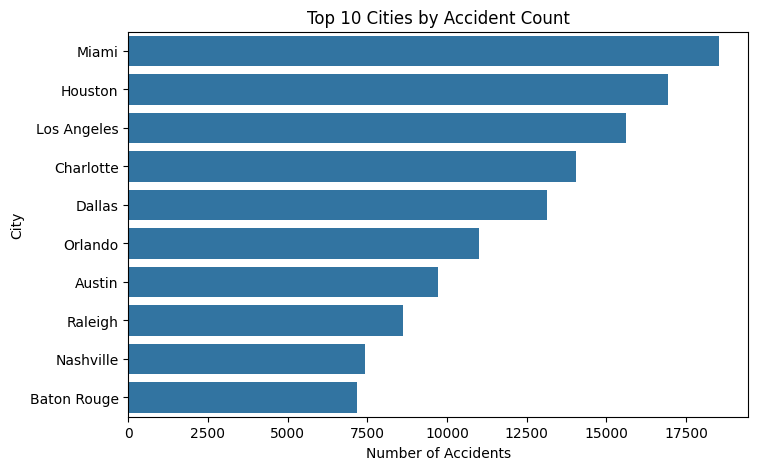

,Top States,Top Cities
Austin,NaN,9715.0
Baton Rouge,NaN,7175.0
CA,173589.0,NaN
Charlotte,NaN,14036.0
Dallas,NaN,13146.0
FL,87287.0,NaN
Houston,NaN,16937.0
Los Angeles,NaN,15628.0
MN,19317.0,NaN
Miami,NaN,18525.0


In [3]:
top_states = df['State'].value_counts().head(10)
plt.figure(figsize=(8,4))
sns.barplot(x=top_states.index, y=top_states.values)
plt.title('Top 10 States by Accident Count')
plt.xlabel('State')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()

top_cities = df['City'].value_counts().head(10)
plt.figure(figsize=(8,5))
sns.barplot(x=top_cities.values, y=top_cities.index)
plt.title('Top 10 Cities by Accident Count')
plt.xlabel('Number of Accidents')
plt.ylabel('City')
plt.show()

summary_table = pd.DataFrame({
    'Top States': top_states,
    'Top Cities': top_cities
})
summary_table

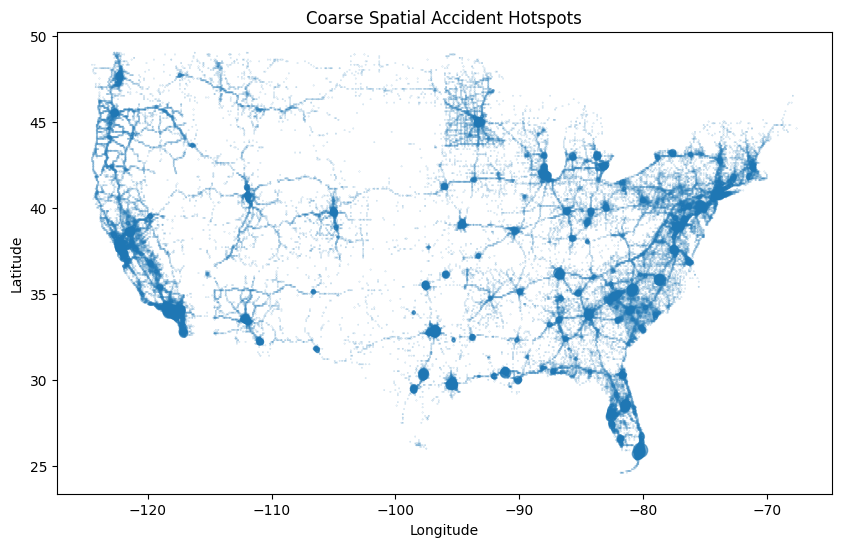

Hotspot near lat 25.9, lng -80.2 with 5251.0 accidents
Hotspot near lat 34.0, lng -118.2 with 4006.0 accidents
Hotspot near lat 35.2, lng -80.8 with 3491.0 accidents
Hotspot near lat 25.7, lng -80.4 with 3415.0 accidents
Hotspot near lat 32.8, lng -96.8 with 3253.0 accidents


In [5]:
geo_df['lat_bin'] = geo_df['Start_Lat'].round(1)
geo_df['lng_bin'] = geo_df['Start_Lng'].round(1)

grid_density = (
    geo_df
    .groupby(['lat_bin', 'lng_bin'])
    .size()
    .reset_index(name='accident_count')
    .sort_values('accident_count', ascending=False)
)

grid_density.head(10)
plt.figure(figsize=(10,6))
plt.scatter(
    grid_density['lng_bin'],
    grid_density['lat_bin'],
    s=grid_density['accident_count'] / 50,
    alpha=0.6
)
plt.title('Coarse Spatial Accident Hotspots')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

hotspots = grid_density.head(5)
hotspots
for _, row in hotspots.iterrows():
    print(
        f"Hotspot near lat {row['lat_bin']}, lng {row['lng_bin']} "
        f"with {row['accident_count']} accidents"
    )


 Q2. Spatial–Temporal Patterns within a State

**Question:**  
**How do accident patterns vary by time of day and month within a specific high-accident state (e.g., CA or TX), and are these patterns spatially concentrated?**

### Tasks

1. Choose one state with a high number of accidents and create hourly and monthly distributions of accidents (bar plots).  
2. Overlay or compare these distributions with maps for selected hours (e.g., peak vs off-peak) or seasons (e.g., winter vs summer) to see whether certain locations within the state become more active at specific times.  
3. Describe any spatial–temporal clusters you observe (e.g., urban cores at rush hour, specific corridors in certain months).


In [7]:
state = 'CA'
ca_df = df[df['State'] == state].copy()
ca_df['Start_Time'] = pd.to_datetime(
    ca_df['Start_Time'],
    format='mixed',
    errors='coerce'
)
ca_df = ca_df.dropna(subset=['Start_Time'])
ca_df['hour'] = ca_df['Start_Time'].dt.hour
ca_df['month'] = ca_df['Start_Time'].dt.month


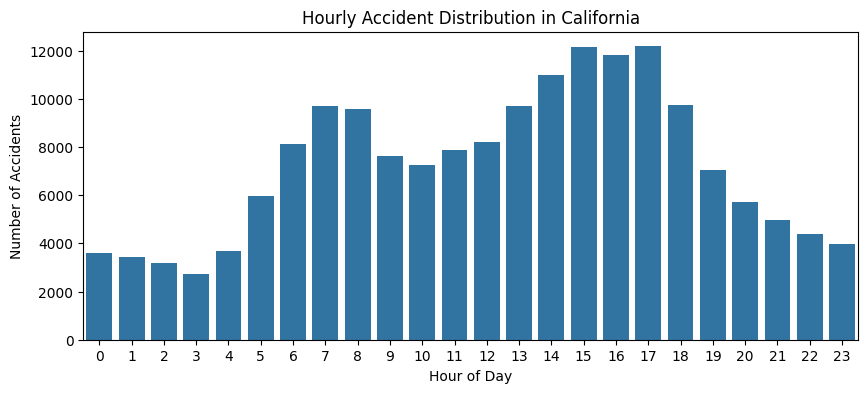

In [8]:
hourly_counts = ca_df['hour'].value_counts().sort_index()

plt.figure(figsize=(10,4))
sns.barplot(x=hourly_counts.index, y=hourly_counts.values)
plt.title('Hourly Accident Distribution in California')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Accidents')
plt.show()


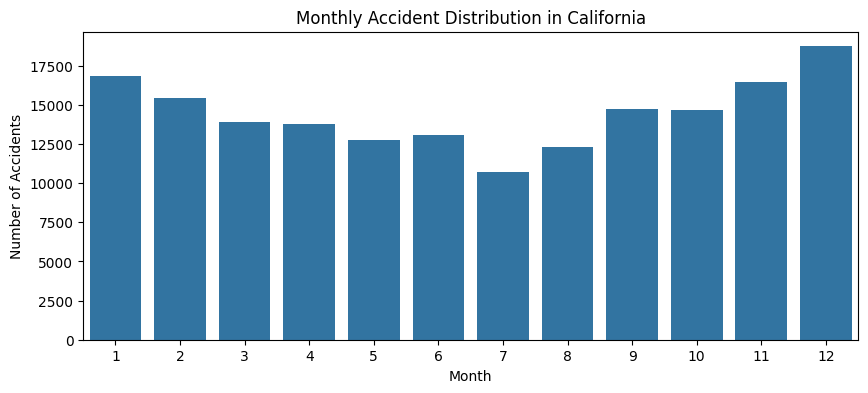

In [9]:
monthly_counts = ca_df['month'].value_counts().sort_index()

plt.figure(figsize=(10,4))
sns.barplot(x=monthly_counts.index, y=monthly_counts.values)
plt.title('Monthly Accident Distribution in California')
plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.show()


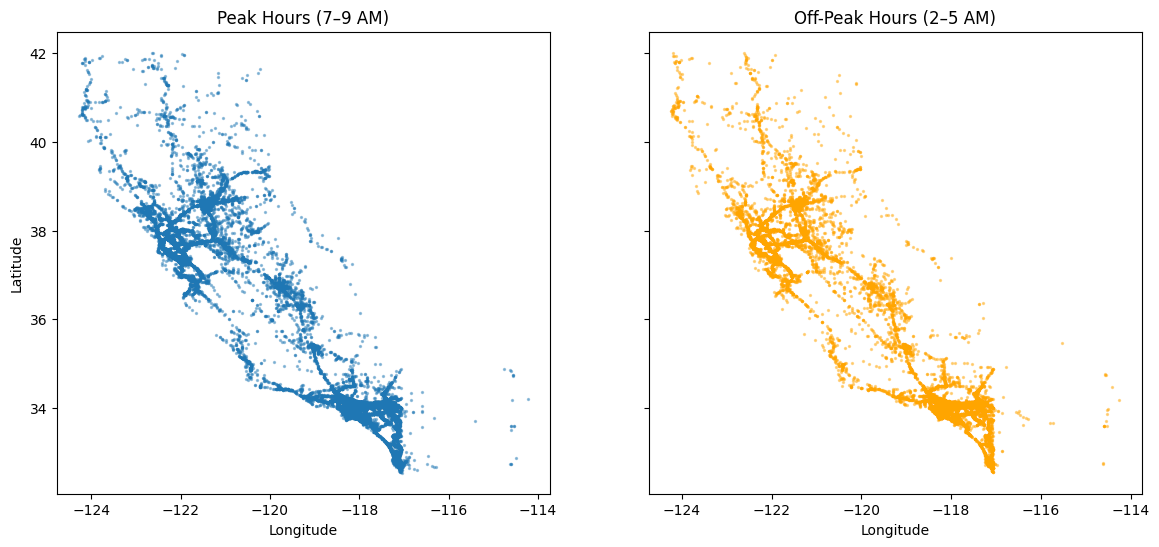

In [10]:
ca_geo = ca_df.dropna(subset=['Start_Lat', 'Start_Lng'])
peak_hours = ca_geo[ca_geo['hour'].between(7, 9)]
offpeak_hours = ca_geo[ca_geo['hour'].between(2, 5)]
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

axes[0].scatter(
    peak_hours['Start_Lng'],
    peak_hours['Start_Lat'],
    s=2,
    alpha=0.4
)
axes[0].set_title('Peak Hours (7–9 AM)')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

axes[1].scatter(
    offpeak_hours['Start_Lng'],
    offpeak_hours['Start_Lat'],
    s=2,
    alpha=0.4,
    color='orange'
)
axes[1].set_title('Off-Peak Hours (2–5 AM)')
axes[1].set_xlabel('Longitude')

plt.show()



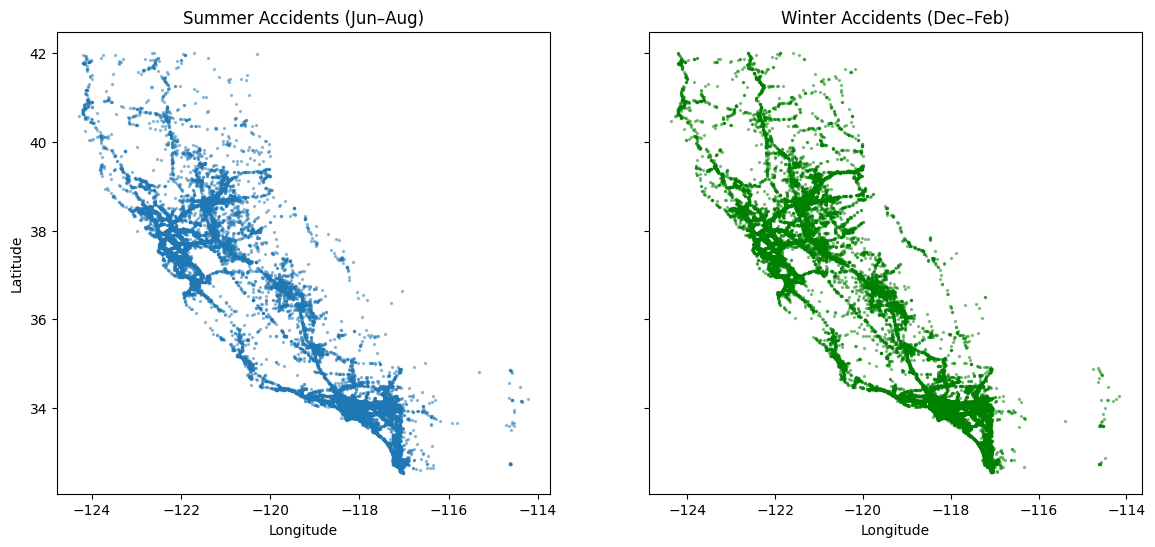

In [11]:
summer = ca_geo[ca_geo['month'].isin([6, 7, 8])]
winter = ca_geo[ca_geo['month'].isin([12, 1, 2])]
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

axes[0].scatter(
    summer['Start_Lng'],
    summer['Start_Lat'],
    s=2,
    alpha=0.4
)
axes[0].set_title('Summer Accidents (Jun–Aug)')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

axes[1].scatter(
    winter['Start_Lng'],
    winter['Start_Lat'],
    s=2,
    alpha=0.4,
    color='green'
)
axes[1].set_title('Winter Accidents (Dec–Feb)')
axes[1].set_xlabel('Longitude')

plt.show()


## Q3. Geospatial Correlates of Severity

**Question:**  
**How does accident severity vary across space, and what geospatial or contextual factors appear associated with high-severity accidents?**

### Tasks

1. Map accidents colored (or otherwise distinguished) by severity level to see how severe accidents are distributed geographically.  
2. Compare severity distributions across a few selected cities or states, or across urban vs non-urban areas, using plots and maps.  
3. Relate severity to at least one additional spatial/context variable (e.g., weather conditions, presence of junctions/crossings, proximity to highways) and discuss any spatial pattern that emerges.


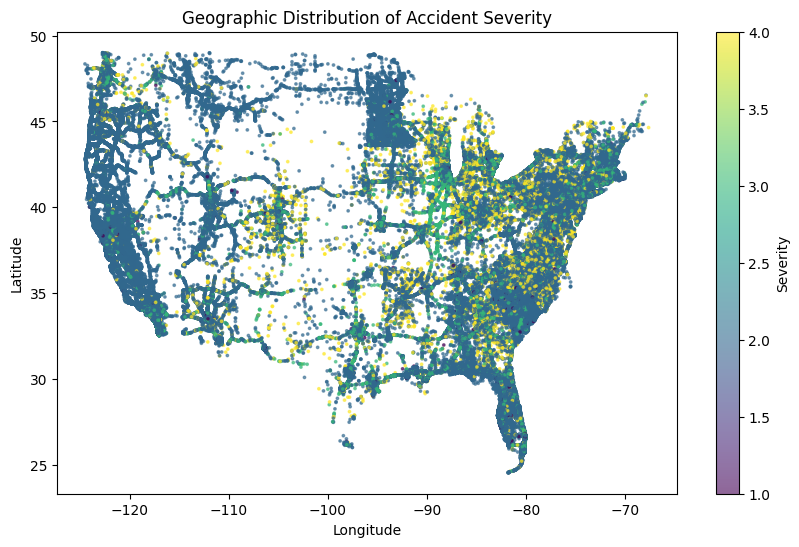

In [13]:
sev_df = df.dropna(subset=['Start_Lat', 'Start_Lng', 'Severity']).copy()
plt.figure(figsize=(10,6))
scatter = plt.scatter(
    sev_df['Start_Lng'],
    sev_df['Start_Lat'],
    c=sev_df['Severity'],
    cmap='viridis',
    s=3,
    alpha=0.6
)
plt.colorbar(scatter, label='Severity')
plt.title('Geographic Distribution of Accident Severity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


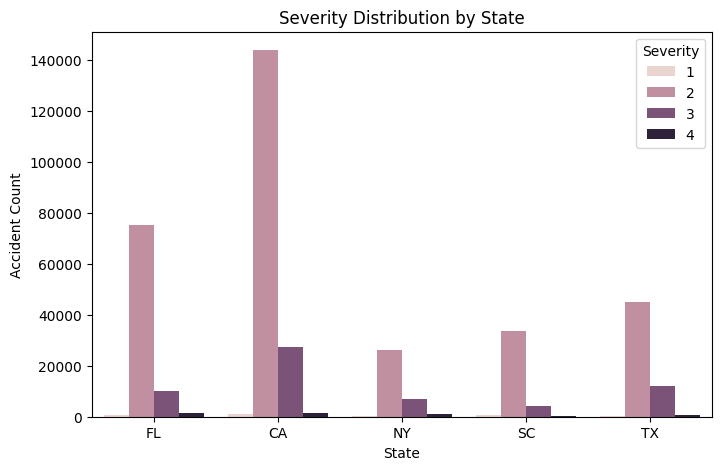

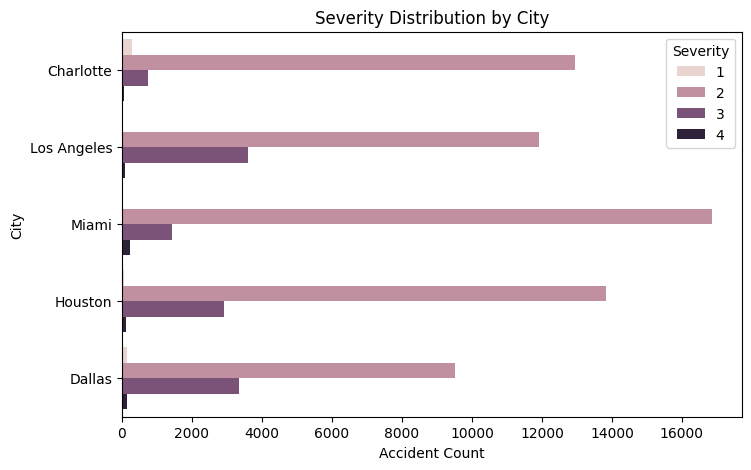

In [15]:
top_states = sev_df['State'].value_counts().head(5).index

state_sev = sev_df[sev_df['State'].isin(top_states)]

plt.figure(figsize=(8,5))
sns.countplot(data=state_sev, x='State', hue='Severity')
plt.title('Severity Distribution by State')
plt.ylabel('Accident Count')
plt.show()

top_cities = sev_df['City'].value_counts().head(5).index

city_sev = sev_df[sev_df['City'].isin(top_cities)]

plt.figure(figsize=(8,5))
sns.countplot(data=city_sev, y='City', hue='Severity')
plt.title('Severity Distribution by City')
plt.xlabel('Accident Count')
plt.show()


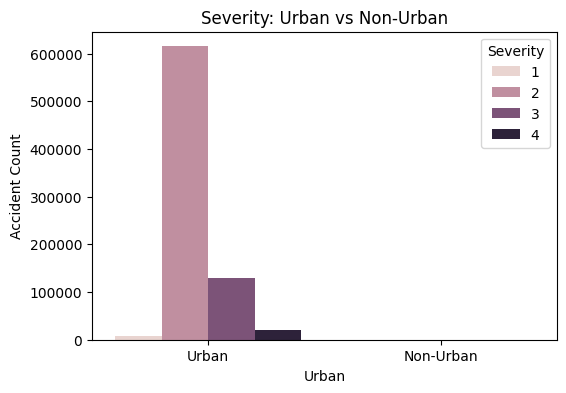

In [16]:
sev_df['Urban'] = np.where(sev_df['City'].notna(), 'Urban', 'Non-Urban')

plt.figure(figsize=(6,4))
sns.countplot(data=sev_df, x='Urban', hue='Severity')
plt.title('Severity: Urban vs Non-Urban')
plt.ylabel('Accident Count')
plt.show()


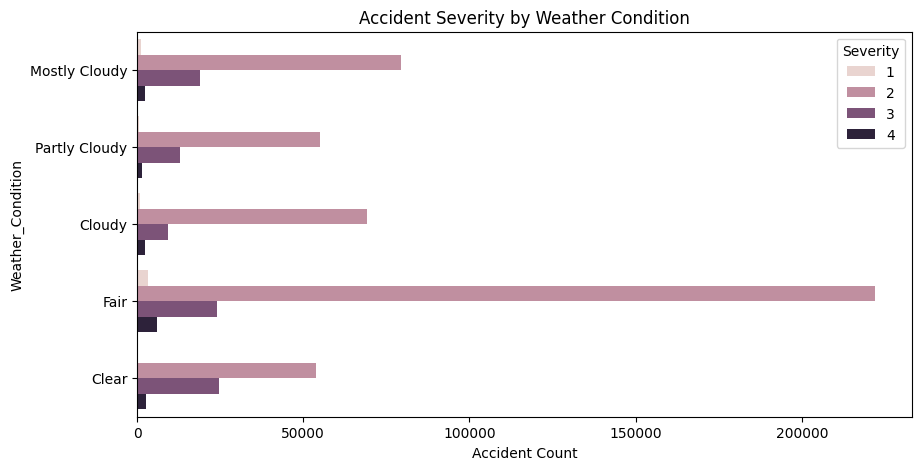

In [17]:
common_weather = sev_df['Weather_Condition'].value_counts().head(5).index

weather_sev = sev_df[sev_df['Weather_Condition'].isin(common_weather)]

plt.figure(figsize=(10,5))
sns.countplot(
    data=weather_sev,
    y='Weather_Condition',
    hue='Severity'
)
plt.title('Accident Severity by Weather Condition')
plt.xlabel('Accident Count')
plt.show()


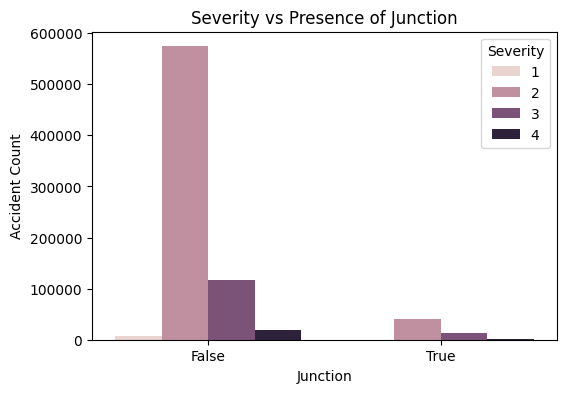

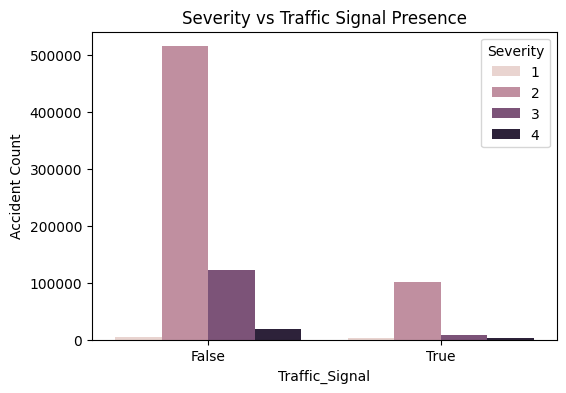

In [18]:
plt.figure(figsize=(6,4))
sns.countplot(data=sev_df, x='Junction', hue='Severity')
plt.title('Severity vs Presence of Junction')
plt.ylabel('Accident Count')
plt.show()
plt.figure(figsize=(6,4))
sns.countplot(data=sev_df, x='Traffic_Signal', hue='Severity')
plt.title('Severity vs Traffic Signal Presence')
plt.ylabel('Accident Count')
plt.show()


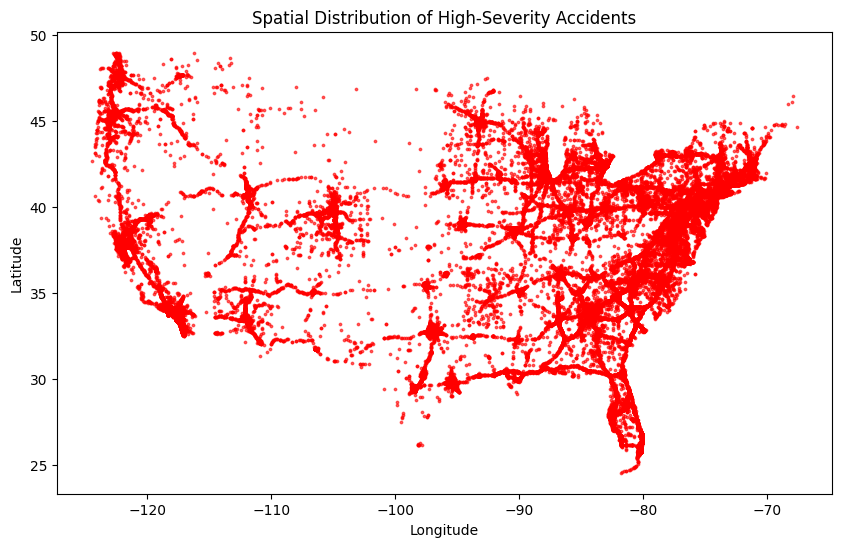

In [19]:
high_sev = sev_df[sev_df['Severity'] >= 3]
plt.figure(figsize=(10,6))
plt.scatter(
    high_sev['Start_Lng'],
    high_sev['Start_Lat'],
    s=3,
    alpha=0.6,
    color='red'
)
plt.title('Spatial Distribution of High-Severity Accidents')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
